In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)
from collections import OrderedDict, Counter
from itertools import product
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set(font_scale=1)
sns.set_style("white")
sns.set_style("ticks")
import os
import sys
sys.path.insert(0, '../../src')
from utils import ProcessData
from starlette.config import Config

import unicodedata
from tqdm import tqdm
import re
import io
import msoffcrypto

from googletrans import Translator
import googlemaps

from sklearn.metrics import auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error,mean_absolute_error
import xgboost as xgb
from hyperopt.pyll.base import scope 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import smogn
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

translator = Translator()
config = Config("../../../../../.env")
pw = config("HASEKO_DATA_PW", cast=str)
# google_api_key = config("HASEKO_GOOGLE_API_KEY", cast=str)
# gmaps = googlemaps.Client(key=google_api_key)

%matplotlib inline

In [2]:
def get_boundaries(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def remove_outliers(df, column):
    lower_bound, upper_bound = get_boundaries(df, column)
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def reverse_transform(X, tr):
    for name, transfo in enumerate(list(tr[0])):
        if transfo =='Squared':
            X = np.squeeze(np.square(X))
        elif transfo == 'Log':
            X = np.squeeze(np.expm1(X))
        else:
            X = np.squeeze(X)
    return X

def normalization(data,method):
    if method == 'mean':
        # Mean normalization
        x, y = data.mean(), data.std()
        data = (data-x)/y
    elif method == 'minmax':
        # Min-max normalization
        x, y = data.min(), data.max()
        data = (data-x)/(y-x)
    return data, (x.values[0],y.values[0])

def unskew_data(data):
    def process_data(data, idx):
        d = {}
        for i in data.columns:
            method = idx.loc[i,0]
            if method == 'Log':
                d[i] = np.log1p(data[i])
            elif method == 'Squared':
                d[i] = np.sqrt(data[i])
            else:
                d[i] = data[i]
        data_pr = pd.DataFrame(data=d, columns = data.columns)
        data_pr = data_pr.fillna(data_pr.mean())
        return data_pr
    
    data = data.astype(float)

    data_log = pd.DataFrame(np.log1p(data), columns= data.columns)
    data_square = pd.DataFrame(np.sqrt(data), columns= data.columns)

    data_skewness = pd.concat([data.skew(), data_log.skew(), data_square.skew()], axis=1)
    data_skewness.columns = ['Raw','Log','Squared']
    data_min = data_skewness.abs().idxmin(axis=1).to_frame()
    data_unskewed = process_data(data, data_min)
    
    return data_unskewed, data_min

# New training data

In [3]:
area = {'1100': 'Saitama',
        '1200': 'Chiba',
        '1301': 'Central Tokyo',
        '1302': 'Western Tokyo',
        '1303': 'Eastern Tokyo',
        '1304': 'Tokyo city',
        '1400': 'Kanagawa'}

new_dict = ['年齢\nage','合算後年収.1\nAnnual income after the sum .1', '家族数\nFamily number',
            '家族F\nFamily F','物件価格(千円)\nProperty price (1,000 yen)', '面積\narea','LP名\nLP name',
            '最新住所\nLatest address']

In [53]:
data_dir = '../../haseko_v1_data_analysis/data/コピーデータ240215_4回目.xls'
unlocked_file = io.BytesIO()

excel_file = msoffcrypto.OfficeFile(open(data_dir, "rb"))
excel_file.load_key(password = pw)
excel_file.decrypt(unlocked_file)
df = pd.read_excel(unlocked_file)

df.columns = [unicodedata.normalize('NFKC', s) for s in df.columns]
df.columns = [s+'\n'+str(translator.translate(s, dest='en').text) for s in df.columns]

df['物件価格(千円)\nProperty price (1,000 yen)'] /= 10
df['借入金額(百万円単位)\nBorrowed amount (million yen units)'] *= 100

df = df.rename(columns={'物件価格(千円)\nProperty price (1,000 yen)':'物件価格(万円)\nProperty price', '借入金額(百万円単位)\nBorrowed amount (million yen units)':'借入金額(万円)\nBorrowed amount'})

# Remove outlier
df = remove_outliers(df, '面積\narea')

# Remove possible pair loan
col = ['家族数\nFamily number','家族F\nFamily F','物件価格(万円)\nProperty price','面積\narea','LP名\nLP name','最新住所\nLatest address']
dup = df[df.duplicated(subset=col, keep=False)]
df = df.loc[[i for i in df.index if i not in dup.index],:]

df['diff'] = [i-j for i,j in zip(df['物件価格(万円)\nProperty price'], df['借入金額(万円)\nBorrowed amount'])]

print(df.shape)
df.head(5)

(3740, 13)


,NO\nNO,LP名\nLP name,実行年\nExecution,家族F\nFamily F,家族数\nFamily number,年齢\nage,合算後年収\nAnnual income after the sum,合算後年収.1\nAnnual income after the sum .1,借入金額(万円)\nBorrowed amount,物件価格(万円)\nProperty price,面積\narea,最新住所\nLatest address,diff
2,100003,今回追加したデータ,2019,DINKS,2,36,～800万円,8,3000,3298.0,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前,298.0
3,100005,今回追加したデータ,2019,独身,1,48,～400万円,4,2500,3378.0,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前,878.0
4,100007,今回追加したデータ,2019,独身,1,42,～500万円,4,2800,3598.0,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前,798.0
5,100008,今回追加したデータ,2019,独身,3,29,～500万円,4,1800,2588.0,30.72,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前,788.0
6,100009,今回追加したデータ,2019,独身,1,51,～400万円,4,2400,3448.0,35.73,さいたま市浦和区 上木崎 １－９－１７ シティインデックス 与野駅前,1048.0


# Data visualization

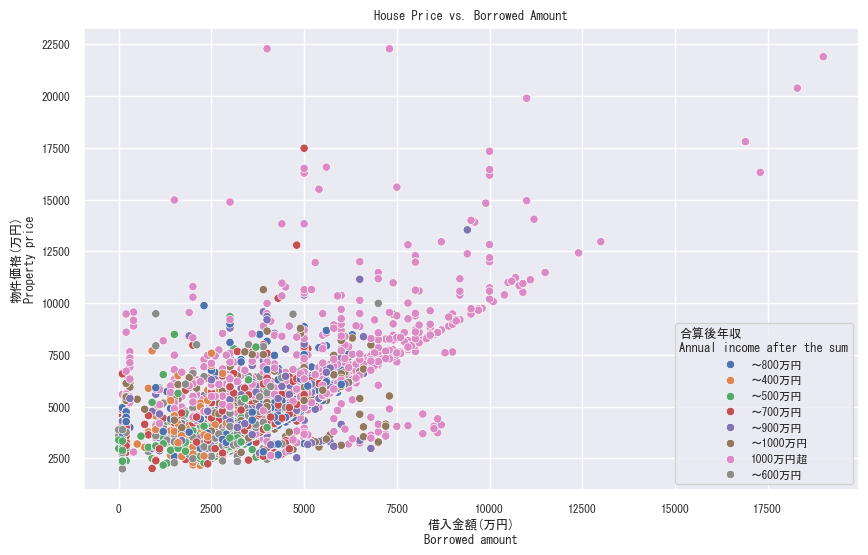

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='借入金額(万円)\nBorrowed amount', y='物件価格(万円)\nProperty price', hue="合算後年収\nAnnual income after the sum")
plt.title('House Price vs. Borrowed Amount')
plt.show()

In [42]:
# # One-hot encode the categorical variable if necessary
# col = ['合算後年収\nAnnual income after the sum','借入金額(百万円単位)\nBorrowed amount (million yen units)']
# df = df[col]

# # # df.isna().sum()

# encoder = OneHotEncoder(sparse=False)
# encoded_salary = encoder.fit_transform(df[['合算後年収\nAnnual income after the sum']])
# encoded_salary_df = pd.DataFrame(encoded_salary, columns=encoder.get_feature_names_out(['合算後年収\nAnnual income after the sum']))
# df_encoded = pd.concat([df.drop('合算後年収\nAnnual income after the sum', axis=1), encoded_salary_df], axis=1)

# # Regression analysis
# X = df_encoded.drop('借入金額(百万円単位)\nBorrowed amount (million yen units)', axis=1)  # Independent variables
# y = df_encoded['借入金額(百万円単位)\nBorrowed amount (million yen units)']  # Dependent variable

# # # Adding constant for intercept
# X = sm.add_constant(X)

# model = sm.OLS(y, X).fit()
# print(model.summary())

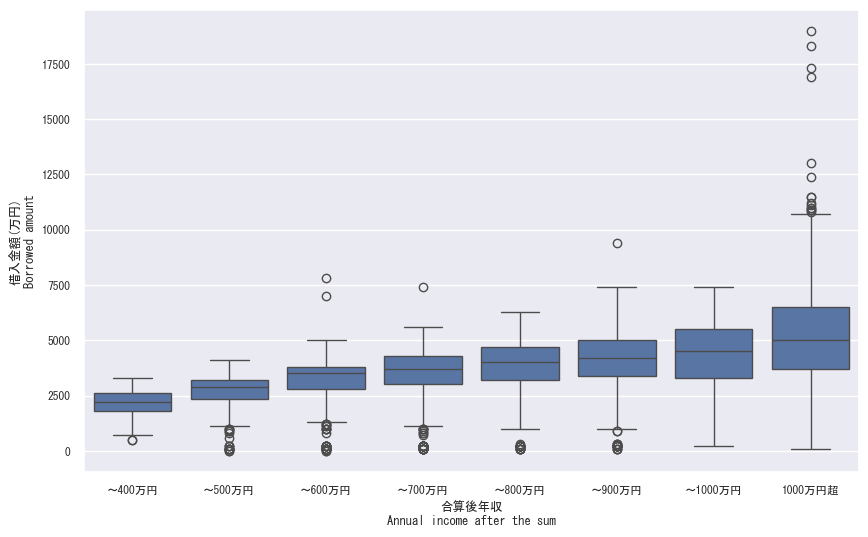

In [56]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=0.75, font="MS Gothic")
order = ['～400万円', '～500万円', '～600万円', '～700万円', '～800万円', '～900万円', '～1000万円','1000万円超']
sns.boxplot(x='合算後年収\nAnnual income after the sum', y='借入金額(万円)\nBorrowed amount', data=df, order=order)
plt.show()

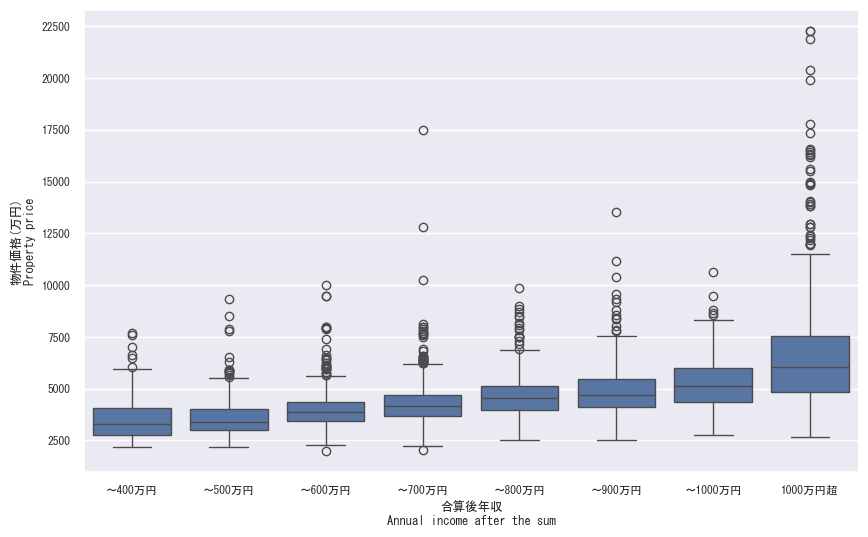

In [61]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=0.75, font="MS Gothic")
order = ['～400万円', '～500万円', '～600万円', '～700万円', '～800万円', '～900万円', '～1000万円','1000万円超']
sns.boxplot(x='合算後年収\nAnnual income after the sum', y='物件価格(万円)\nProperty price', data=df, order=order)
plt.show()

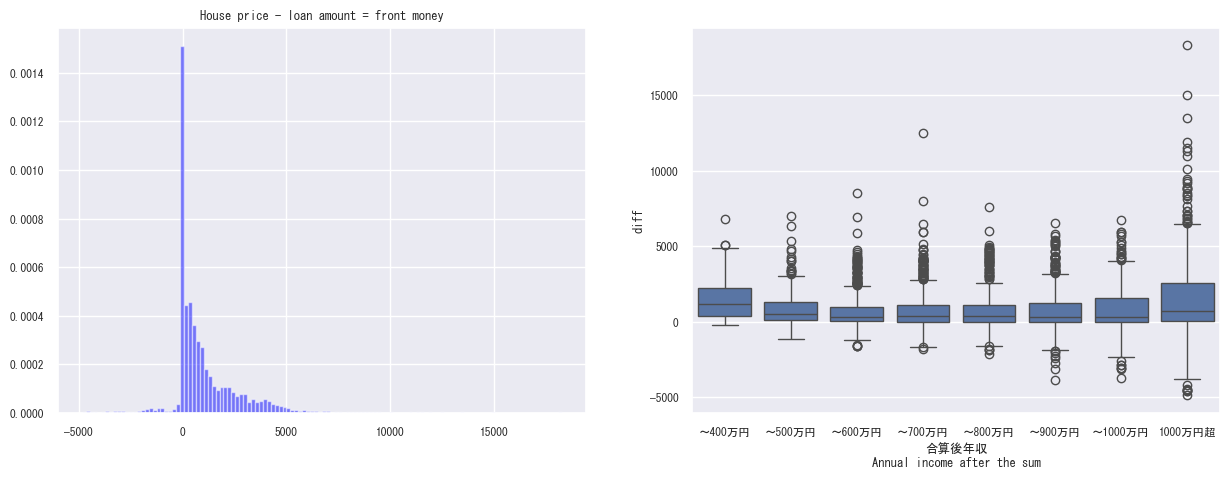

In [57]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df['diff'], bins='auto', alpha=0.5, color='blue', density=True)
plt.title('House price - loan amount = front money')
plt.subplot(1,2,2)
sns.set(font_scale=0.75, font="MS Gothic")
order = ['～400万円', '～500万円', '～600万円', '～700万円', '～800万円', '～900万円', '～1000万円','1000万円超']
sns.boxplot(x='合算後年収\nAnnual income after the sum', y='diff', data=df, order=order)
plt.show()

# Large difference (house - loan) user investigation

In [60]:
check = df[df['diff']>2500]
print(check.shape)
check.head(15)

(556, 13)


,NO\nNO,LP名\nLP name,実行年\nExecution,家族F\nFamily F,家族数\nFamily number,年齢\nage,合算後年収\nAnnual income after the sum,合算後年収.1\nAnnual income after the sum .1,借入金額(万円)\nBorrowed amount,物件価格(万円)\nProperty price,面積\narea,最新住所\nLatest address,diff
30,100049,マンション中心のLPの案件,2020,独身,3,45,～500万円,4,2000,4578.0,65.18,横須賀市 小川町 １０－１ バウス横須賀中央,2578.0
45,100067,今回追加したデータ,2019,ファミリー,3,64,～700万円,6,1400,5398.0,78.32,横浜市旭区 柏町 １３０－４,3998.0
55,100081,マンション中心のLPの案件,2020,独身,1,49,～600万円,6,1000,5080.0,55.04,横浜市磯子区 中原 ２－３－１１,4080.0
62,100088,マンション中心のLPの案件,2021,ファミリー,3,37,1000万円超,14,300,7654.0,75.55,横浜市栄区 笠間 ２－２－２,7354.0
63,100089,マンション中心のLPの案件,2022,独身,2,50,～800万円,8,1400,4348.0,66.71,横浜市栄区 小菅ヶ谷 １－２２－１ ブランズシティ本郷台,2948.0
66,100092,マンション中心のLPの案件,2022,独身,2,47,～500万円,5,2200,4864.0,67.47,横浜市栄区 小菅ヶ谷 １－２２－１ ブランズシティ本郷台,2664.0
74,100100,マンション中心のLPの案件,2023,独身,3,22,～400万円,3,2000,4898.0,71.27,横浜市栄区 小菅ヶ谷 １－２２－２ ブランズシティ本郷台 リバーサイドテラス,2898.0
82,100111,マンション中心のLPの案件,2022,DINKS,2,55,～400万円,3,1500,6050.0,74.93,横浜市栄区 小菅ヶ谷 １－５－３ パークホームズ横浜本郷台ＴＨＥ ＥＡＳＴ,4550.0
83,100112,マンション中心のLPの案件,2022,独身,1,55,～600万円,6,3000,7380.0,90.00,横浜市栄区 小菅ヶ谷 １－５－３ パークホームズ横浜本郷台ＴＨＥ ＥＡＳＴ,4380.0
112,100143,マンション中心のLPの案件,2021,DINKS,2,34,～700万円,6,200,4973.0,67.95,横浜市戸塚区 吉田町 ７７８－１０ ルネ横浜戸塚,4773.0
